In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/home/tim/Desktop/Desktop/DELFT/APPLIED PHYSICS - MASTER/Modeling and Data Analysis in Complex Networks/ASSIGNMENTS/ASSIGNMENT 1/SFHH2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Create an undirected graph from the dataset
G = nx.Graph()

# Add edges, ignoring time steps
edges = df[['id1', 'id2']].drop_duplicates().values.tolist()
G.add_edges_from(edges)

# 1. Number of nodes (N)
N = len(G.nodes())

# 2. Number of links (L)
L = len(G.edges())

# 3. Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# 4. Compute the average degree E[D]
E_D = np.mean(degrees)

# 5. Compute the standard deviation of the degree sqrt(Var[D])
std_D = np.std(degrees)

# Print results
print("Number of nodes (N):", N)
print("Number of links (L):", L)
print("Average degree (E[D]):", E_D)
print("Standard deviation of the degree (sqrt(Var[D])):", std_D)


Number of nodes (N): 401
Number of links (L): 9415
Average degree (E[D]): 46.957605985037404
Standard deviation of the degree (sqrt(Var[D])): 29.918521078014955


A2

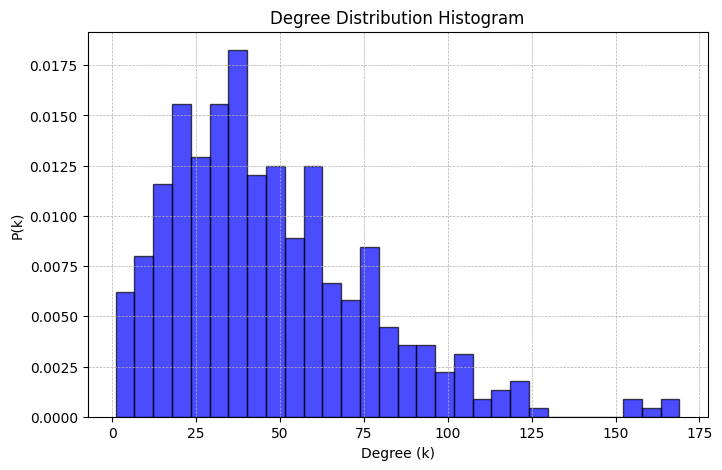

In [5]:
# Compute degree of each node
degrees = np.array([d for _, d in G.degree()])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=30, color="blue", alpha=0.7, edgecolor="black", density=True)

# Set y-axis to log scale
# plt.yscale("log")

# Labels and title
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution Histogram")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Looks like ER random model --> needs further assessment

A3

In [6]:
assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity coefficient (ρD):", assortativity)

Degree assortativity coefficient (ρD): -0.08190596963063947


ρ D <0 (Disassortative Mixing): High-degree nodes tend to connect to low-degree nodes. This is often seen in technological and biological networks (e.g., power grids, metabolic networks).If your dataset represents a contact network, a positive assortativity (ρD>0ρ D​	 >0) suggests that individuals with many contacts tend to interact with other well-connected individuals. A negative assortativity (ρD<0ρ D<0) suggests that well-connected individuals interact more frequently with those who have fewer connections, which is often seen in epidemic spread models.

A4

In [ ]:
clustering_local = nx.clustering(G)  # Returns a dictionary {node: c_i}
C_avg = nx.average_clustering(G)
print("Average clustering coefficient (C):", C_avg)

In [ ]:
!which python

: 